In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fromaaron.asat_sma import period
import rebound.units as u
from functions import *
Mearthkg = u.masses_SI['mearth']
Msunkg = u.masses_SI['solarmass']
Mearth = Mearthkg / Msunkg
G = u.G_SI

In [2]:
import math

def p_geq_k(lam, k):
    prob = 0
    for i in range(k):
        #print(i)
        prob += lam**i * np.exp(-lam) / math.factorial(i)
        #print(prob)
    prob = np.round(prob, 15)
    #print(prob)
    Prob = 1 - prob
    return Prob * 100

def p_k(lam, k):
    p = lam**k * np.exp(-lam) / math.factorial(k)
    return np.round(p, 15) * 100

In [3]:
nsbm1 = pd.read_hdf('satall/sims/NSBM/data_0.003_1000_0.13_3.0.hdf', 
                    key='data')
nsbm2 = pd.read_hdf('satall/sims/NSBM/data_0.1_1000_0.13_3.0.hdf',
                    key='data')
r1 = pd.read_hdf('satall/sims/rayleigh/data_0.05_1000_0.13_3.0.hdf', 
                 key='data')
r2 = pd.read_hdf('satall/sims/rayleigh/data_0.04_1000_0.13_3.0.hdf', 
                 key='data')
r3 = pd.read_hdf('satall/sims/rayleigh/data_0.1_500_0.13_3.0.hdf', 
                 key='data')


In [4]:
scales = [1168, 1168, 1168, 333536, 333536, 333536]
rlist = [nsbm2, r1, r2, nsbm1, r1, r2]
for i, df in enumerate(rlist):
    colprob = (1-np.exp(-np.sum(df.colprob.values)*scales[i]/len(df)))*100
    print('scaled: ', colprob)
    colprob = (1-np.exp(-np.sum(df.colprob.values)))*100
    print('unscaled: ', colprob)
    colprob = p_geq_k(np.sum(df.colprob.values), 1)
    print('function: ', colprob, '\n')




scaled:  1.739163596550064
unscaled:  1.4908848011426223
function:  1.4908848011426001 

scaled:  6.148295764490285
unscaled:  5.2877919103480275
function:  5.287791910348005 

scaled:  7.680040593749182
unscaled:  6.6128045929039425
function:  6.612804592903898 

scaled:  89.68853397710264
unscaled:  0.6788453298251507
function:  0.6788453298251951 

scaled:  99.99999864936235
unscaled:  5.2877919103480275
function:  5.287791910348005 

scaled:  99.99999998770423
unscaled:  6.6128045929039425
function:  6.612804592903898 



In [5]:
scale = 1168
i = 0
df = r2
lam = np.sum(df.colprob.values)
lam_scaled = lam * scale/len(df)
scaled = []
unscaled = []
prob_scaled = []
prob_unscaled = []
kvals = np.arange(0,101,1)
for k in kvals:
    prob_scaled.append(p_k(lam_scaled, k))
    prob_unscaled.append(p_k(lam, k))
    scaled.append(p_geq_k(lam_scaled, k))
    unscaled.append(p_geq_k(lam, k))

In [837]:
def vel_dis_NBM(mtarget, mkill, vkill, vtarget, rtar, nbins, Lc_min, Lc_max, 
                KEkill, numsample, makev=True, normalize=True):
    M = mtarget + mkill
    if KEkill / mtarget / 1000 >= 40:
        print('catastrophic collision')
        Me = mkill + mtarget
    else:
        print('cratering collision')
        Me = 2 * KEkill / 1000 ** 2
    print('Ejected Mass initial calc: ', Me)
    def dNum(L0, L1, Me):
        '''
        NASA Standard Breakup Model is used to find the 
        number of debris fragments for a particular bin
        of characteristic lengths Lc.
        '''
        N0 = 0.1 * Me ** (0.75) * L0 ** (-1.71)
        N1 = 0.1 * Me ** (0.75) * L1 ** (-1.71)
        return int(N0 - N1)

    Lc_bins = np.logspace(np.log10(Lc_min), np.log10(Lc_max), nbins+1)       
    L_mids = (Lc_bins[1:] + Lc_bins[:-1]) / 2
    nums = []
    print('first loop')
    for i in range(len(Lc_bins)-1):
        Lc_l = Lc_bins[i]
        Lc_h = Lc_bins[i+1]
        num = int(dNum(Lc_l, Lc_h, Me))
        nums.append(num)
    nums = np.array(nums).astype(int)
    AMfrags = get_AM_ratio(L_mids, nums)
    N_tot = len(AMfrags)
    Afrags, mfrags, Lcvals = get_A_M_vals(L_mids, AMfrags, nums)
    M_tot = np.sum(mfrags)
    print('N_tot:', N_tot)
    print('M_tot: ', M_tot)
    
    if normalize:
        print('normalizing')
        nums = nums * Me / M_tot
        nums = nums.astype(int)
    AMfrags = get_AM_ratio(L_mids, nums)
    Afrags, mfrags, Lcvals = get_A_M_vals(L_mids, AMfrags, nums)
    M_tot = np.sum(mfrags)
    N_tot = len(AMfrags)
    print(N_tot==np.sum(nums))
    print('Number of debris: ', N_tot)
    print('Total mass of debris:', M_tot)

    if normalize:
        while M_tot > Me:
            print('normalizing')
            nums = nums * Me / M_tot
            nums = nums.astype(int)
            AMfrags = get_AM_ratio(L_mids, nums)
            Afrags, mfrags, Lcvals = get_A_M_vals(L_mids, AMfrags, nums)
            M_tot = np.sum(mfrags)
            N_tot = len(AMfrags)
            print(N_tot==np.sum(nums))
            print('Number of debris: ', N_tot)
            print('Total mass of debris:', M_tot)

    
    if makev == False:
        if numsample == 100:
            return N_tot
        else:
            return numsample
    
    elif makev == True:
        print('making velocities')
        
        if numsample == 100:
            vfrags = get_delta_vs(AMfrags)

            GM = G * Mearthkg
            vfrags_total = vfrags + vtarget
            eccs = []
            SMA = []
            for v in vfrags_total:
                ecc = mag(eccVector(v, GM, rtar))
                a = sma(v, GM, mag(rtar))
                eccs.append(ecc)
                SMA.append(a)

            eccs = np.array(eccs)
            SMA = np.array(SMA)

            return N_tot, L_mids, nums, mfrags, vfrags, vfrags, vfrags_total, eccs, SMA, AMfrags, AMfrags, Lcvals, Lcvals   
        
        elif numsample != 100:
            vfrags_all = get_delta_vs(AMfrags)
            
            indices = np.linspace(0, len(AMfrags)-1, len(AMfrags)).astype(int)
            sample = np.random.choice(indices, numsample, replace=True)
            AMsample = AMfrags[sample]
            Lcsample = Lcvals[sample]
            vfrags = get_delta_vs(AMsample)


            GM = G * Mearthkg
            vfrags_total = vfrags + vtarget
            eccs = []
            SMA = []
            for v in vfrags_total:
                ecc = mag(eccVector(v, GM, rtar))
                a = sma(v, GM, mag(rtar))
                eccs.append(ecc)
                SMA.append(a)

            eccs = np.array(eccs)
            SMA = np.array(SMA)

            return N_tot, L_mids, nums, mfrags, vfrags_all, vfrags, vfrags_total, eccs, SMA, AMfrags, AMsample, Lcvals, Lcsample



In [402]:
def b_gamma_of_L(Lc):
    if Lc <= 0.00167:
        b = 0.540424
        gamma = 2.
    else:
        b = 0.556945
        gamma = 2.0047077
    return b, gamma

def p_lam(Lc, L_min, L_max=1.0):
    b, gamma = b_gamma_of_L(Lc)
    lam = np.log10(Lc)
    lam0 = np.log10(L_min)
    lam1 = np.log10(L_max)
    
    def pL(b, Lc, L_min, L_max):
        return b * Lc**(-(b+1)) / (L_min**(-b)-L_max**(-b))
    
    p_lam = np.log(10)*Lc * pL(Lc)
    

<ipython-input-209-6a0e359ab7c9>:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(dis), bins=100, density=True);


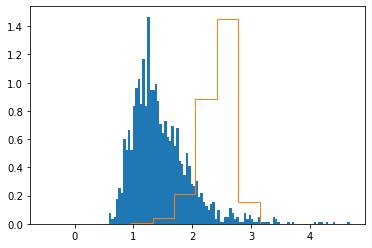

In [209]:
plt.hist(np.log10(dis), bins=100, density=True);
plt.hist(np.log10(vmagsR), histtype='step', density=True);

In [ ]:
    for i in range(len(L[flag])):
        num = numsM[i]
        pS = scipy.stats.norm(muS[i], sig_S[i]).pdf(chi)
        pL = aL_1[i] * scipy.stats.norm(muL_1[i], sigL_1[i]).pdf(chi) + aL_2[i] * scipy.stats.norm(muL_2[i], sigL_2[i]).pdf(chi)
        pM = a[i] * pL + (1-a[i]) * pS
        cdfM = np.cumsum(pM*dchi)
        P = np.random.uniform(size=num)
        cdfindices = np.digitize(P, bins=cdfM)
        cdfindices[cdfindices==len(chi)] = len(chi) - 1
        chis = np.append(chis, chi[cdfindices])
        
    # large objects:
    flag = L>0.11
    numsL = nums[flag]
    a1, a2 = aL1[flag], aL2[flag]
    mu1, mu2 = muL1[flag], muL2[flag]
    sig1, sig2 = sigL1[flag], sigL2[flag]
    for i in range(len(L[flag])):
        num = numsL[i]
        pL = a1[i] * scipy.stats.norm(mu1[i], sig1[i]).pdf(chi) + a2[i] * scipy.stats.norm(mu2[i], sig2[i]).pdf(chi)
        cdfL = np.cumsum(pL*dchi)
        P = np.random.uniform(size=num)
        cdfindices = np.digitize(P, bins=cdfL)
        cdfindices[cdfindices==len(chi)] = len(chi) - 1
        chis = np.append(chis, chi[cdfindices])

In [1202]:
from scipy.stats import maxwell as maxwell
import scipy.stats

In [853]:
vs = np.log10(np.logspace(0.0001,5,10000))
dv = (vs[1:]-vs[:-1])[0]

vx = []
vy = []
vz = []

for AMval in AMfrags:
    chi = np.log10(AMval)
    mu = 0.9 * chi + 2.9
    sigma = 0.4 
    pv = scipy.stats.norm(mu, sigma).pdf(vs)
    cdf = np.cumsum(pv*dv)
    P = np.random.uniform(size=1)
    cdfindices = np.digitize(P, bins=cdf)
    cdfindices[cdfindices==len(vs)] = len(vs) - 1
    magv = 10**vs[cdfindices]
    unitvecs = np.random.uniform(-1, 1, (1, 3))
    vnormed = (unitvecs.T / np.linalg.norm(unitvecs, axis=1)).T
    vfrag = (vnormed.T * magv).T
    vx.append(vfrag[:,0])
    vy.append(vfrag[:,1])
    vz.append(vfrag[:,2])

In [854]:
vx = np.array(vx)
vy = np.array(vy)
vz = np.array(vz)
magv = np.sqrt(vx**2+vy**2+vz**2)

In [855]:
vmags = np.sqrt(vfrags[:,0]**2+vfrags[:,1]**2+vfrags[:,2]**2)

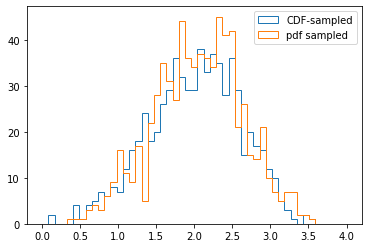

In [856]:
edges, bins, _ = plt.hist(np.log10(magv), bins=np.linspace(0,4,50), histtype='step', label='CDF-sampled');
edges, bins, _ = plt.hist(np.log10(vmags), bins=bins, histtype='step', label='pdf sampled');
#plt.hist(np.log10(vmagsR), bins=bins, histtype='step', label='rayleigh');
plt.legend()

In [857]:
vcdf = np.append(np.append(vx, vy, axis=1), vz, axis=1)
GM = G * Mearthkg
vfrags_total_cdf = vcdf + vtarget
eccscdf = []
SMAcdf = []
for v in vfrags_total_cdf:
    ecc = mag(eccVector(v, GM, rtarget))
    a = sma(v, GM, mag(rtarget))
    eccscdf.append(ecc)
    SMAcdf.append(a)

In [964]:
vR = vfragsR
GM = G * Mearthkg
vfrags_total_R = vR + vtarget
eccsR = []
SMAR = []
for v in vfrags_total_R:
    ecc = mag(eccVector(v, GM, rtarget))
    a = sma(v, GM, mag(rtarget))
    eccsR.append(ecc)
    SMAR.append(a)

In [858]:
SMAcdf =np.array(SMAcdf)
eccscdf = np.array(eccscdf)

In [859]:
p = SMA*(1-eccs)/1000-REkm
q = SMA*(1+eccs)/1000-REkm

In [740]:
qcdf = SMAcdf*(1+eccscdf)/1000-REkm
pcdf = SMAcdf*(1-eccscdf)/1000-REkm

In [741]:
len(pcdf[(pcdf>200)&(eccscdf<1)&(qcdf<2500)])

389

(0, 4.5)

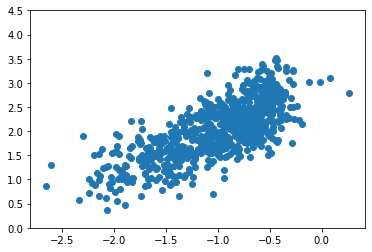

In [742]:
plt.scatter(np.log10(AMfrags), np.log10(magv))
plt.ylim(0,4.5)

(0.19996560327887092, 4)

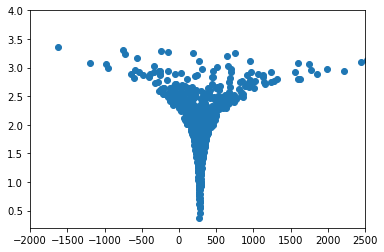

In [743]:
plt.scatter(SMAcdf/1000-REkm, np.log10(magv))
plt.xlim(-2000,2500)
plt.ylim(top=4)

In [744]:
len(SMAcdf[SMAcdf/1000-REkm>200])

548

(-0.23871207643941508, 4)

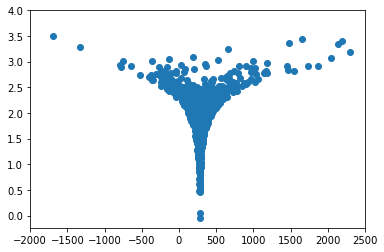

In [745]:
plt.scatter(SMA/1000-REkm, np.log10(vmags))
plt.xlim(-2000,2500)
plt.ylim(top=4)

In [746]:
len(nsbm2.loc[np.log10(nsbm2.vkick)<1])/len(nsbm2)

0.04804804804804805

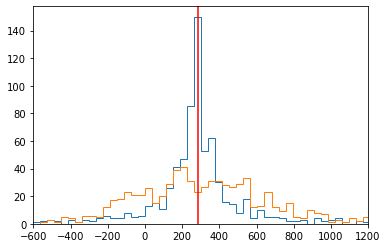

In [973]:
edges,bins,_= plt.hist(SMA/1000-REkm, bins=500, histtype='step');
plt.hist(np.array(SMAR)/1000-REkm, bins=bins, histtype='step');
plt.xlim(-600,1200)
plt.axvline(283, color='r')

In [976]:
SMAR=np.array(SMAR)
len(SMAR[SMAR/1000-REkm>200])

433

In [979]:
np.sqrt(G*Mearthkg/mag(rtarget))

7735.691960387545

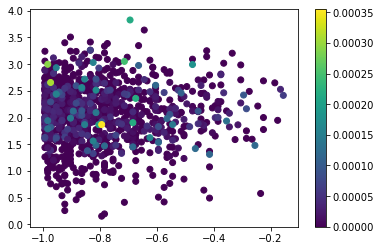

In [747]:
df = nsbm2
a = df.SMA/1000-REkm
q = df.SMA*(1+df.ecc)/1000-REkm
p = df.SMA*(1-df.ecc)/1000-REkm
vkicks = df.vkick
plt.scatter(np.log10(df.Lc), np.log10(vkicks), c=df.colprob)
plt.colorbar()

In [748]:
lowv = nsbm2.loc[nsbm2.vkick<10]
highv = nsbm2.loc[nsbm2.vkick>=10]

In [749]:
(1-np.exp(-np.sum(highv.colprob.values)))*100

1.490880919511084

In [750]:
checker = nsbm3
checker = checker.loc[(checker.Lc>=0.1)&(checker.vkick<10)].append(nsbm3.loc[nsbm3.Lc<0.1])

<ipython-input-750-e2a583d66fad>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  checker = checker.loc[(checker.Lc>=0.1)&(checker.vkick<10)].append(nsbm3.loc[nsbm3.Lc<0.1])


In [751]:
(1-np.exp(-np.sum(checker.colprob.values)*333333/len(checker)))*100

91.68387336336077

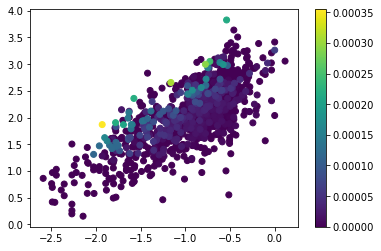

In [752]:
nsbm2 = nsbm2.loc[nsbm2.t_deorbit<1e6]
plt.scatter(np.log10(nsbm2.AM.values), np.log10(nsbm2.vkick.values), c=nsbm2.colprob.values)
plt.colorbar()

In [494]:
lowv = nsbm2.loc[nsbm2.vkick<=10]
np.sum(lowv.colprob.values)/np.sum(nsbm2.colprob.values)

2.623228285257222e-06

Text(0.5, 1.0, '84.91% deorbited after 3 years')

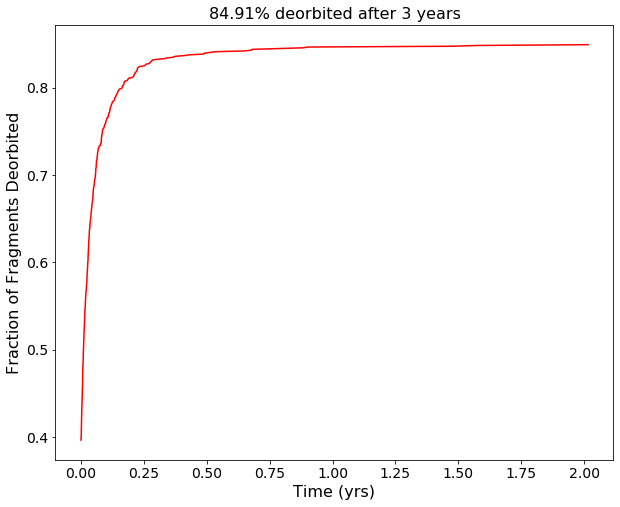

In [504]:
datadf = nsbm2.loc[nsbm2.vkick>10]
maxtime = 3
NFOLLOW = 1168 - 48
timedf = pd.DataFrame(datadf.loc[datadf.t_deorbit < 1e6].t_deorbit.values.T, columns=['time'])
cumsum = np.cumsum(timedf.groupby('time').size().values)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(timedf.groupby('time').first().index.values/twopi, cumsum/NFOLLOW, lw=1.5, color='r')
plt.xlabel('Time (yrs)', fontsize=16)
plt.ylabel('Fraction of Fragments Deorbited', fontsize=16)
ax.tick_params(labelsize=14)
plt.title('{:.4}% deorbited after {} years'.format(cumsum[-1]/NFOLLOW*100, maxtime), fontsize=16)



(0, 4.5)

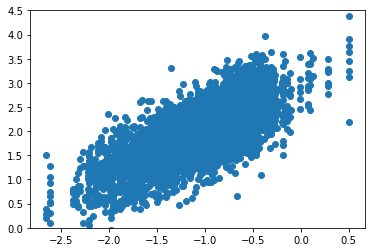

In [464]:
plt.scatter(np.log10(AMfrags), np.log10(vmags))
plt.ylim(0,4.5)

<ipython-input-508-7508d342f24f>:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(SMAcdf), np.log10(magv))


(0, 4.5)

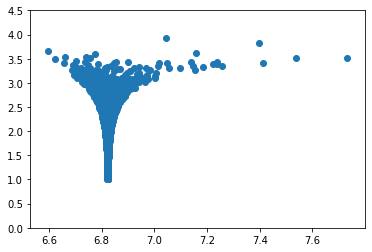

In [508]:
plt.scatter(np.log10(SMAcdf), np.log10(magv))
plt.ylim(0,4.5)

In [5]:
SEED=314
np.random.seed(SEED)
from NSBM_functions import *

mtarget = 740
mkill = 10
vkill = 3.4e3
Q = 288.7 + REkm
q = 267.4 + REkm
r = 283 + REkm
a = (Q + q) * 1000 / 2
vr = np.sqrt(G * (Mearthkg + mtarget) * (2/(r*1000) - 1/a))
inc = 96.6 * np.pi / 180
omega = 17 * np.pi / 180
vtarget, rtarget = get_target_params(mtarget, vr, r, Q, inc, omega)
nbins = 100
Lc_min = 0.1
Lc_max = 1.0
KEkill = 130e6
numsample = 100
N_tot, L_mids, nums, mfrags, vfrags_all, vfrags, vfrags_total, eccs, SMA, AMfrags_all, AMfrags, Lcvals_all, Lcvals  = vel_dis_NBM(mtarget, 
                                                                                                                  mkill, 
                                                                                                                  vkill, 
                                                                                                                  vtarget, 
                                                                                                                  rtarget, 
                                                                                                                  nbins, 
                                                                                                                  Lc_min, 
                                                                                                                  Lc_max, 
                                                                                                                  KEkill, 
                                                                                                                  numsample, 
                                                                                                                  makev=True)


[-1245.59931005   752.09134181  6500.13553492]
283.0000000000018
7598.593642757243 164.96827627231005 1425.7791509032206
7732.9610154893035
catastrophic collision
Ejected Mass initial calc:  750
first loop
N_tot: 671
M_tot:  414.3867481385325
normalizing
True
Number of debris:  1168
Total mass of debris: 518.0180372873651
making velocities


In [8]:
flag = (SMA*(1-eccs)/1000-REkm>200)&(SMA*(1+eccs)/1000-REkm<2500)&(eccs<1)
len(SMA[flag])

647

In [1430]:
vmag = np.sqrt(vfrags[:,0]**2+vfrags[:,1]**2+vfrags[:,2]**2)

In [1431]:
def get_delta_vs(AM, k):
    np.random.seed(314)
    print(k)
    chi = np.log10(AM)
    mu = 0.9 * chi + 2.9
    sigma = 0.4 * np.ones(len(chi))
    v = np.random.normal(loc=mu, scale=sigma, size=np.array([1, len(chi)]))
    magdv = 10 ** v[0]
    if k == -1:
        unitvecs = np.random.uniform(-1, 1, (len(magdv), 3))
    if k == 0:
        unitvecs = np.random.normal(0, 1, (len(magdv), 3))
    print(unitvecs)
    vnormed = (unitvecs.T / np.linalg.norm(unitvecs, axis=1)).T
    vfrags = (vnormed.T * magdv).T
    return vfrags

In [1432]:
vfragR = get_delta_vs(AMfrags, -1)
vR = vfragR
GM = G * Mearthkg
vfrags_total_R = vR + vtarget
eccsR = []
SMAR = []
for v in vfrags_total_R:
    ecc = mag(eccVector(v, GM, rtarget))
    a = sma(v, GM, mag(rtarget))
    eccsR.append(ecc)
    SMAR.append(a)
SMAR = np.array(SMAR)
eccsR = np.array(eccsR)
vmagR = np.sqrt(vfragR[:,0]**2+vfragR[:,1]**2+vfragR[:,2]**2)

-1
[[ 0.28366538  0.30141981  0.80081963]
 [-0.99806646  0.65273078  0.03964336]
 [-0.4629463  -0.15902532 -0.26448431]
 ...
 [-0.91988741 -0.79179837  0.77067524]
 [ 0.42059301 -0.63217615  0.92307163]
 [-0.02476693  0.24095996  0.1168292 ]]


In [1433]:
vfragR0 = get_delta_vs(AMfrags, 0)
vR = vfragR0
GM = G * Mearthkg
vfrags_total_R = vR + vtarget
eccsR0 = []
SMAR0 = []
for v in vfrags_total_R:
    ecc = mag(eccVector(v, GM, rtarget))
    a = sma(v, GM, mag(rtarget))
    eccsR0.append(ecc)
    SMAR0.append(a)
SMAR0 = np.array(SMAR0)
eccsR0 = np.array(eccsR0)
vmagR0 = np.sqrt(vfragR0[:,0]**2+vfragR0[:,1]**2+vfragR0[:,2]**2)

0
[[ 1.36791617  1.28734228  0.07901933]
 [ 1.30105886 -0.549172   -1.59872117]
 [-1.06344627 -1.91024609 -1.33731722]
 ...
 [-1.178231    1.33311868  0.34982818]
 [ 1.03561966 -0.61693678 -0.96921034]
 [ 0.61175176  0.25479342  0.13136636]]


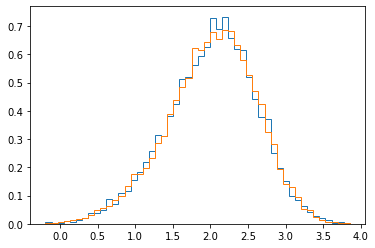

In [1434]:
edges, bins,_ = plt.hist(np.log10(vmag), bins=50, histtype='step', density=True);
plt.hist(np.log10(vmagR0), bins=bins, histtype='step', density=True);

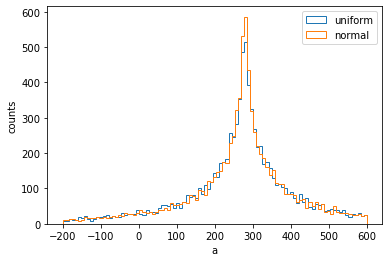

In [1435]:
edges, bins, _ = plt.hist(SMA/1000-REkm, bins=np.linspace(-200,600,100),histtype='step', label='uniform');
plt.hist(SMAR0/1000-REkm, bins=bins, histtype='step', label='normal');
plt.xlabel('a')
plt.ylabel('counts')
plt.legend()

In [1418]:
q = SMA*(1-eccs)/1000-REkm

In [1422]:
np.sum(q<200)

306

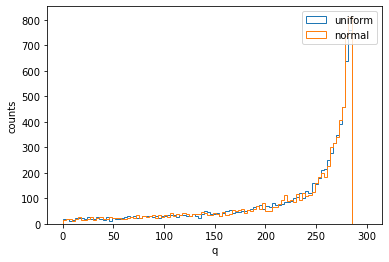

In [1441]:
edges, bins, _ = plt.hist(SMA*(1-eccs)/1000-REkm, bins=np.linspace(0,300,100),histtype='step', label='uniform');
plt.hist(SMAR0*(1-eccsR0)/1000-REkm, bins=bins, histtype='step', label='normal');
plt.xlabel('q')
plt.ylabel('counts')
plt.legend()

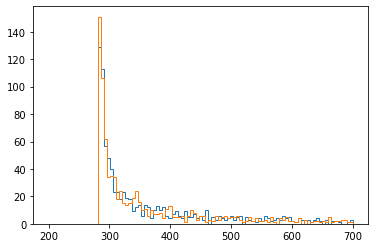

In [1402]:
edges, bins, _ = plt.hist(SMA*(1+eccs)/1000-REkm, bins=np.linspace(200,700,100),histtype='step');
plt.hist(SMAR0*(1+eccsR0)/1000-REkm, bins=bins, histtype='step');

In [1448]:
twopi = 2 * np.pi
(twopi/2 - (9/12)/22*twopi)

2.9273931544813983

In [1449]:
0.93*np.pi

2.921681167838508

In [1183]:
def get_delta_vs(AM):
    chi = np.log10(AM)
    mu = 0.9 * chi + 2.9
    sigma = 0.4 * np.ones(len(chi))
    v = np.random.normal(loc=mu, scale=sigma, size=np.array([1, len(chi)]))
    magdv = 10 ** v[0]
    unitvecs = np.random.uniform(0, 1, (len(magdv), 3))
    vnormed = (unitvecs.T / np.linalg.norm(unitvecs, axis=1)).T
    vfrags = (vnormed.T * magdv).T
    return vfrags

In [1180]:
vfragsR = get_delta_vs(AMfrags)
vfragtot = vfrags
vfragtot[:,0] += 7738
vkicks = np.linalg.norm(vfrags, axis=1)

In [1151]:
rtarget

array([-1245599.31004799,   752091.34181366,  6500135.53492363])

In [1188]:
GM = G * Mearthkg
vfrags_total_R = get_delta_vs(AMfrags) + vtarget
eccsR = []
SMAR = []
for v in vfrags_total_R:
    ecc = mag(eccVector(v, GM, rtarget))
    a = sma(v, GM, mag(rtarget))
    eccsR.append(ecc)
    SMAR.append(a)
SMAR = np.array(SMAR)
eccsR = np.array(eccsR)

(-1000, 1000)

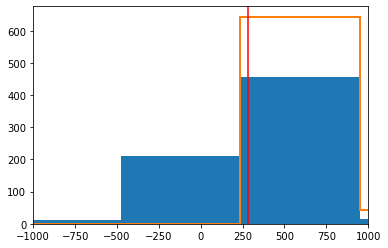

In [1187]:
edges,bins,_=plt.hist(SMA[SMA/1000-REkm<1e4]/1000-REkm, bins=500);
plt.hist(SMAR/1000-REkm, bins=bins, histtype='step', lw=2);
plt.axvline(283, color='r')
plt.xlim(-1000,1000)

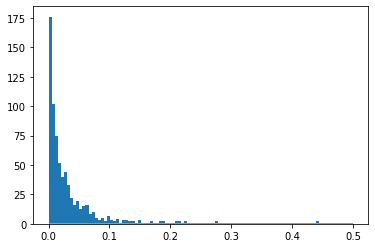

In [1153]:
edges,bins,_=plt.hist(eccs[SMA/1000-REkm<1e4], bins=np.linspace(0,0.5,100));
plt.hist(eccsR, bins=bins, histtype='step', lw=2);

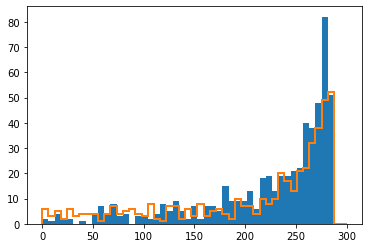

In [1061]:
flag = SMA/1000-REkm<1e4
edges,bins,_=plt.hist((SMA*(1-eccs))[flag]/1000-REkm, bins=np.linspace(0, 300));
plt.hist(SMAR*(1-eccsR)/1000-REkm, bins=bins, histtype='step', lw=2);

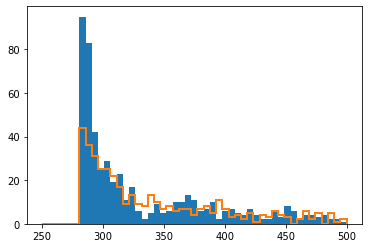

In [1063]:
flag = SMA/1000-REkm<1e4
edges,bins,_=plt.hist((SMA*(1+eccs))[flag]/1000-REkm, bins=np.linspace(250,500));
plt.hist(SMAR*(1+eccsR)/1000-REkm, bins=bins, histtype='step', lw=2);

In [1103]:
vtarmag = mag(vtarget)
vfrags_test = vfrags
vfrags_test[:,0] += vtarmag

In [1114]:
vR = vfrags_test
GM = G * Mearthkg
vfrags_total_R = vR
eccsR = []
SMAR = []
for v in vfrags_total_R:
    ecc = mag(eccVector(v, GM, [mag(rtarget),0,0]))
    a = sma(v, GM, mag(rtarget))
    eccsR.append(ecc)
    SMAR.append(a)
SMAR = np.array(SMAR)
eccsR = np.array(eccsR)

In [1070]:
Q = SMA*(1+eccs)/1000-REkm
q = SMA*(1-eccs)/1000-REkm
good = (Q<2500)&(q>200)&(eccs<1)
len(SMA[good])

407

In [1068]:
Q = SMAR*(1+eccsR)/1000-REkm
q = SMAR*(1-eccsR)/1000-REkm
good = (Q<2500)&(q>200)&(eccsR<1)
len(SMAR[good])

301

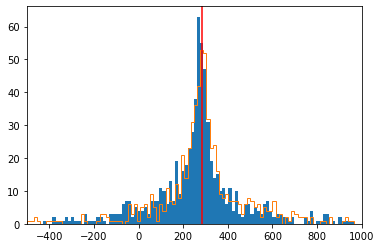

In [888]:
edges,bins,_=plt.hist(SMA/1000-REkm, bins=500);
plt.hist(SMAcdf/1000-REkm, bins=bins, histtype='step');
plt.xlim(-500,1000)
plt.axvline(283, color='r')

In [1175]:
unitvecs = np.random.uniform(-1, 1, (len(magv[:,0]), 3))
vnormed = (unitvecs.T / np.linalg.norm(unitvecs, axis=1)).T
vfrags = (vnormed.T * magv[:,0]).T
vfrags_tot = vfrags + vtarget

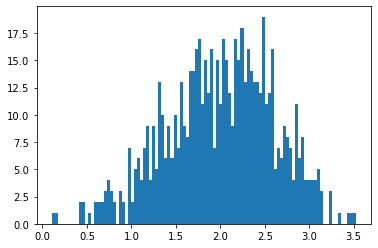

In [1178]:
plt.hist(np.log10(np.linalg.norm(vfrags, axis=1)), bins=100);

In [1167]:
sim = rebound.Simulation()
sim.integrator ="WHFAST"
sim.dt = 1e-7

sim.add(m=Mearth, hash="Earth", r=Ratm)

for i in range(len(vfrags)):
    sim.add(m=740, vx=vfragtot[i,0]/to_m_per_s, vy=vfragtot[i,0]/to_m_per_s, vz=vfragtot[i,0]/to_m_per_s, 
            x=6656000.0/aum, y=0, z=0, hash='{}'.format(i+1))

In [1168]:
atest = []
ps = sim.particles
for i in range(len(vfrags)):
    atest.append(ps[i+1].a*aukm-REkm)
atest = np.array(atest)

In [1171]:
vfragtot

array([[ 8.19094329e+03, -2.17840077e+02,  2.28956485e+02],
       [ 7.68943700e+03,  5.95223655e+01, -1.82331997e+00],
       [ 7.81343540e+03,  1.04663156e+02,  5.62988751e+01],
       ...,
       [ 7.51155987e+03,  4.75971548e+02,  1.18490752e+02],
       [ 7.73823918e+03,  9.90798918e+00,  1.70235875e+01],
       [ 7.92074010e+03,  1.41063464e+02,  5.12697767e+01]])

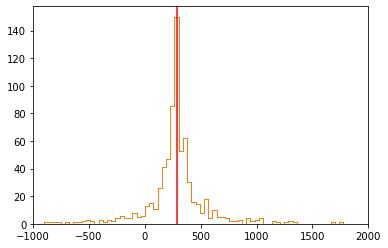

In [950]:
edges,bins,_=plt.hist(atest, bins=500, histtype='step');
plt.hist(SMA/1000-REkm, bins=bins, histtype='step')
plt.xlim(-1000,2000)
plt.axvline(283, color='r')

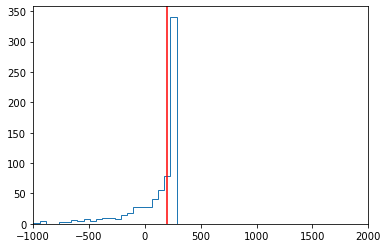

In [942]:
plt.hist(SMA*(1-eccs)/1000-REkm, bins=bins, histtype='step')
plt.xlim(-1000,2000)
plt.axvline(200, color='r')

In [902]:
posfrags = rtarget + np.random.uniform(-10, 10, (len(vfrags),3))
x = posfrags[:,0] / aum
y = posfrags[:,1] / aum
z = posfrags[:,2] / aum

In [910]:
posmags = np.sqrt(posfrags[:,0]**2+posfrags[:,1]**2+posfrags[:,2]**2)

array([4.34507114e-05, 4.34507709e-05, 4.34507126e-05, 4.34506924e-05,
       4.34506875e-05, 4.34507648e-05, 4.34507795e-05, 4.34507195e-05,
       4.34507704e-05, 4.34507502e-05, 4.34507883e-05, 4.34507508e-05,
       4.34506964e-05, 4.34507447e-05, 4.34507332e-05, 4.34507406e-05,
       4.34506668e-05, 4.34507394e-05, 4.34507199e-05, 4.34506600e-05,
       4.34507832e-05, 4.34507042e-05, 4.34507666e-05, 4.34507208e-05,
       4.34506571e-05, 4.34506623e-05, 4.34506631e-05, 4.34507577e-05,
       4.34506823e-05, 4.34507168e-05, 4.34507310e-05, 4.34507441e-05,
       4.34507401e-05, 4.34506949e-05, 4.34506843e-05, 4.34507424e-05,
       4.34507460e-05, 4.34506656e-05, 4.34507069e-05, 4.34507200e-05,
       4.34507809e-05, 4.34507472e-05, 4.34507276e-05, 4.34507305e-05,
       4.34506828e-05, 4.34507454e-05, 4.34507461e-05, 4.34506957e-05,
       4.34506836e-05, 4.34507795e-05, 4.34507511e-05, 4.34506682e-05,
       4.34507653e-05, 4.34507113e-05, 4.34507385e-05, 4.34507257e-05,
      

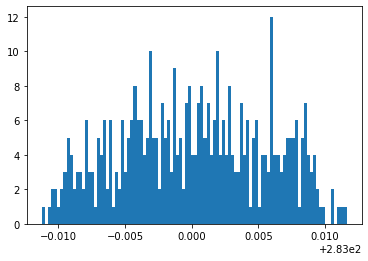

In [850]:
plt.hist(posmags/1000-REkm, bins=100);

In [813]:
def get_target_params(mtarget, vr, r, Q, inc, omega):
    '''
    get the target velocity and position to be combined with
    fragment velocities/positions. The output is in m/s and m
    '''
    a = (2/(r*1e3) - vr**2/(G*Mearthkg))**(-1)/1000
    e = Q/a - 1
    f = np.arccos((a/r*(1-e**2)-1)/e)
    if f < np.pi:
        df = np.pi - f
        f = np.pi + df

    sim = rebound.Simulation()
    sim.integrator ="ias15"
    sim.dt = 1e-7

    sim.add(m=Mearth, hash='Earth', r=Ratm)
    sim.add(m=mtarget/Msunkg, a=a/aukm, f=f, e=e, inc=-inc, Omega=0., omega=omega)

    ps = sim.particles
    x0 = ps[1].x
    y0 = ps[1].y 
    z0 = ps[1].z
    vx0 = ps[1].vx * to_m_per_s
    vy0 = ps[1].vy * to_m_per_s
    vz0 = ps[1].vz * to_m_per_s
    vvec = np.array([vx0, vy0, vz0])
    unitvec = vvec / mag(vvec)
    print(np.array([x0, y0, z0]) * aukm)
    print(mag(np.array([x0, y0, z0]))*aukm-REkm)
    print(vx0, vy0, vz0)
    print(mag(vvec))
    vtarget = vvec
    rtarget = np.array([x0, y0, z0]) * aum
    return vtarget, rtarget

7732.9610154893035

In [962]:
vexpl = 250.
AMval = 0.04
numsample = 720
vfragsR, vfrags_totalR, eccsR, SMAR, AMfragsR = vel_dis_rayleigh(vexpl, vtarget, rtarget, numsample, AMval)

In [963]:
#vmags = np.sqrt(vfrags[:,0]**2+vfrags[:,1]**2+vfrags[:,2]**2)
vmagsR = np.sqrt(vfragsR[:,0]**2+vfragsR[:,1]**2+vfragsR[:,2]**2)
vtot = np.sqrt(vfrags_total[:,0]**2+vfrags_total[:,1]**2+vfrags_total[:,2]**2)

(0, 2000)

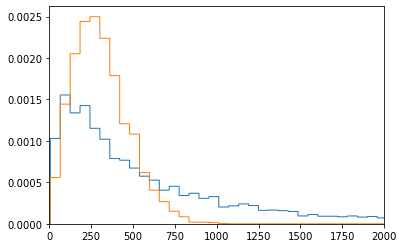

In [451]:
edges, bins, _ = plt.hist((vmags), histtype='step', bins=1000, density=True);
plt.hist((vmagsR), histtype='step', bins=bins, density=True);
plt.xlim(0,2000)

In [123]:
p = SMA*(1-eccs)/1000-REkm
q = SMA*(1+eccs)/1000-REkm

In [128]:
len(p[p>200])

265

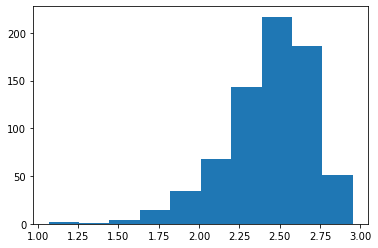

In [125]:
plt.hist(np.log10(vmags));

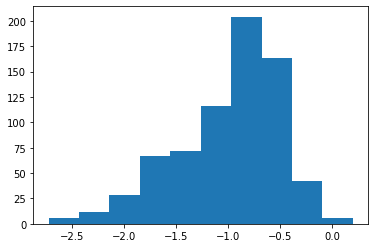

In [78]:
plt.hist(np.log10(AMfrags));

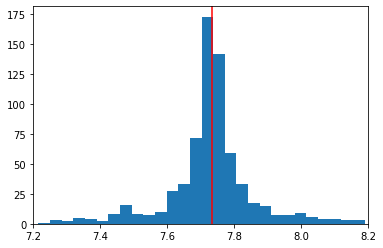

In [79]:
plt.hist(vtot/1e3, bins=200);
plt.xlim(7.2,8.2)
plt.axvline(mag(vtarget)/1e3, color='r')

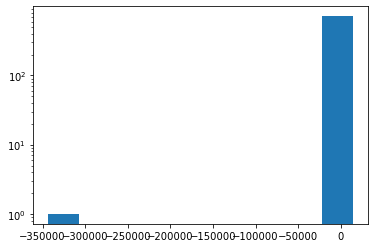

In [80]:
plt.hist(SMA/1e3)
plt.yscale('log')

(-500, 1000)

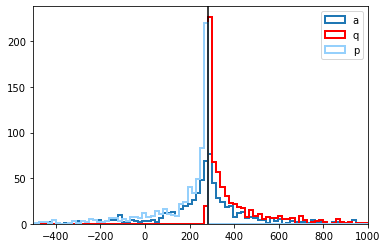

In [81]:
edges, bins, _ = plt.hist(SMA[SMA>0]/1e3-REkm, bins=500, histtype='step', lw=2, label='a');
plt.hist(q[SMA>0], bins=bins, histtype='step', color='r', lw=2, label='q')
plt.hist(p[SMA>0], bins=bins, histtype='step', color='xkcd:light blue', lw=2, label='p')
plt.axvline(mag(rtarget)/1e3-REkm, color='k')
plt.legend()
plt.xlim(-500, 1000)

In [82]:
porb = period(SMA, G*Mearthkg)

/store/users/sthiele/home/js_test/fromaaron/asat_sma.py:19: RuntimeWarning: invalid value encountered in sqrt
  return 2*np.pi*np.sqrt(a**3/GM)


In [87]:
len(porb[(p>0)&(q<2000)])

395

(114.12607847988606, 2000)

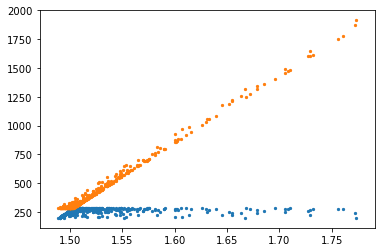

In [88]:
plt.scatter(porb[(p>0)&(q<2000)]/3600, p[(p>0)&(q<2000)], s=5)
plt.scatter(porb[(p>0)&(q<2000)]/3600, q[(p>0)&(q<2000)], s=5)
plt.ylim(top=2000)

In [72]:
len(p[(p>200)&(q<2500)&(eccs<1)])

398

In [252]:
get_target_params(mtarget, vr, r, Q, inc, omega)

278.0499999999993
0.0016000480765621106
[-1245.59931005   752.09134181  6500.13553492]
278.0500000000038
283.0000000000018
7598.593642757243 164.96827627231005 1425.7791509032206
7732.9610154893035
283.0000000000009


(array([7598.59364276,  164.96827627, 1425.7791509 ]),
 array([-1245599.31004799,   752091.34181366,  6500135.53492363]))

In [89]:
deorbit_R = 100
init_deorbit = (SMA*(1-eccs)/1000 <= REkm + deorbit_R)&(eccs<1.0)
ejected = eccs >= 1.0
init_deorbit = len(vfrags[init_deorbit])

keep = (SMA*(1-eccs)/1000>REkm+deorbit_R)&(eccs<1.0)
vfrags = vfrags[keep]
AMfrags = AMfrags[keep]
vfrags_total = vfrags_total[keep] / to_m_per_s
eccs = eccs[keep]
SMA = SMA[keep]
Lcvals = Lcvals[keep]
porb = period(SMA, G*Mearthkg)
q = SMA*(1+eccs)/1e3-REkm
p = SMA*(1-eccs)/1e3-REkm

NFOLLOW = init_deorbit + len(vfrags)

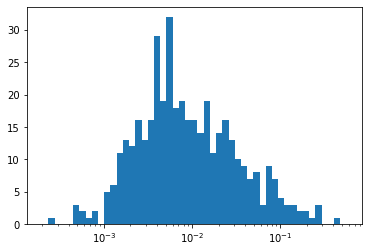

In [396]:
sys.path.insert(1, '/store/users/sthiele/home/junkyspace/')
from NSBM_functions import *

In [91]:
len(SMA[(p>200)&(q<2500)])

398

In [92]:
len(vfrags[(SMA*(1+eccs)/1000-REkm<2500)&(SMA*(1-eccs)/1000 > REkm + 200)&(eccs<1.0)])

398

In [468]:
nsbm3 = pd.read_hdf('satall/sims/NSBM/data_0.003_5000_0.13_3.0.hdf',
                    key='data')
small = nsbm3.loc[nsbm3.Lc<=0.01]
numsmall = np.sum(nums[L_mids<=0.01])
onecm = nsbm3.loc[(nsbm3.Lc>0.01)]
num1cm = np.sum(nums[L_mids>0.01])
fivecm = nsbm3.loc[(nsbm3.Lc>0.05)]
num5cm = np.sum(nums[L_mids>0.05])
tencm = nsbm3.loc[(nsbm3.Lc>0.1)]
num10cm = np.sum(nums[L_mids>0.1])

In [15]:
print(p_geq_k(np.sum(small.colprob.values)*numsmall/len(small), 1))
print(p_geq_k(np.sum(onecm.colprob.values)*num1cm/len(onecm), 1))
print(p_geq_k(np.sum(fivecm.colprob.values)*num5cm/len(fivecm), 1))
print(p_geq_k(np.sum(tencm.colprob.values)*num10cm/len(tencm), 1))

88.1570775344018
28.132867825765995
4.695441232737996
2.0838923121859976


In [16]:
rayleigh = pd.read_hdf('satall/sims/rayleigh/data_0.04_1000_0.13_3.0.hdf', key='data')

In [31]:
kvals, probs = get_pmfs(rayleigh, num10cm, kvals=[1,3,10])
probs

0.053159188716434796


[5.177094689874695, 0.002405978850195112, 0.0]

In [121]:
kvals, probs = get_pmfs(nsbm3, N_tot, kvals=[1,2,5,10])
probs

2.463697332784759


[91.4880347237476, 70.5171285758879, 10.402499195577997, 0.024746872140402054]

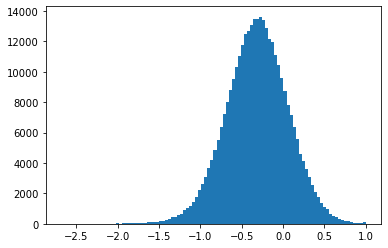

In [136]:
bins, edges, _ = plt.hist(np.log10(AMfrags), bins=100);

In [142]:
mids = (edges[:-1]+edges[1:])/2

In [143]:
np.where(bins==bins.max())

(array([65]),)

In [172]:
len(Lcvals[Lcvals>=0.1])

777

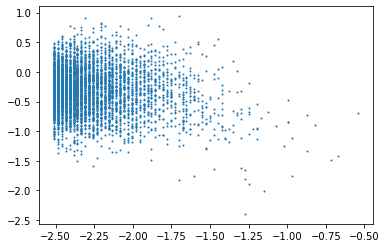

In [169]:
plt.scatter(np.log10(nsbm3.Lc.values), np.log10(nsbm3.AM.values), s=1)

18.12010392996452
15.876821851040221
2.243282078924299
0.14847645843505058
0.04221229718405939


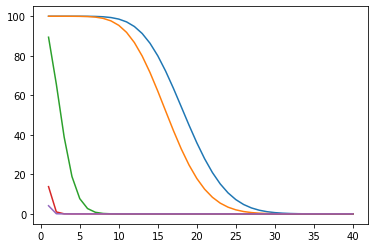

In [109]:
kvals, probs = get_pmfs(rayleigh, N_tot, kvals=None, kmax=40)
plt.plot(kvals, probs)
kvals, probs = get_pmfs(rayleigh, numsmall, kvals=None, kmax=40)
plt.plot(kvals, probs)
kvals, probs = get_pmfs(rayleigh, num1cm, kvals=None, kmax=40)
plt.plot(kvals, probs)
kvals, probs = get_pmfs(rayleigh, num5cm, kvals=None, kmax=40)
plt.plot(kvals, probs)
kvals, probs = get_pmfs(rayleigh, num10cm, kvals=None, kmax=40)
plt.plot(kvals, probs)

In [18]:
def get_pmfs(df, scale, kvals, kmax=None):
    if kmax!=None:
        kvals = np.arange(1, kmax+1, 1)
    lam = np.sum(df.colprob.values) * scale / len(df)
    print(lam)
    probs = []
    for k in kvals:
        p = p_geq_k(lam, k)
        probs.append(p)
    return kvals, (probs)

2.463697332784759
2.133439757124995
0.3303511582643131
0.048092540509163006
0.021059117934324186


Text(0, 0.5, 'P($\\geq$ k)')

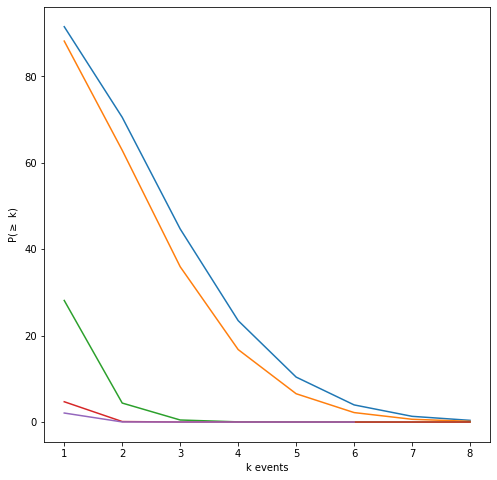

In [36]:
plt.figure(figsize=(8,8))
kvals = None
kmax = 8
dflist = [nsbm3, small, onecm, fivecm, tencm]
scales = [N_tot, numsmall, num1cm, num5cm, num10cm]
for i, df in enumerate(dflist):
    scale = scales[i]
    kvals, probs = get_pmfs(df, scale, kvals, kmax)
    probs = np.array(probs)
    plt.plot(kvals[probs>0], probs[probs>0])

plt.xlabel('k events')
plt.ylabel('P($\geq$ k)')

In [21]:
kvals = [1,3,10]
kvals, probs = get_pmfs(nsbm3, N_tot, kvals)
probs

2.463697332784759


[91.4880347237476, 44.6841458046073, 0.024746872140402054]

In [23]:
kvals = [1,3,10]
kvals, probs = get_pmfs(small, numsmall, kvals)
probs

2.133439757124995


[88.1570775344018, 35.938999041485296, 0.007874072013802635]

In [24]:
kvals, probs = get_pmfs(onecm, num1cm, kvals)
probs

0.3303511582643131


[28.132867825765995, 0.4699795696012976, 3.160027794990583e-10]

In [25]:
kvals, probs = get_pmfs(fivecm, num5cm, kvals)
probs

0.048092540509163006


[4.695441232737996, 0.0017882821787051917, 0.0]

In [26]:
kvals, probs = get_pmfs(tencm, num10cm, kvals)
probs

0.021059117934324186


[2.0838923121859976, 0.00015321930969536268, 0.0]

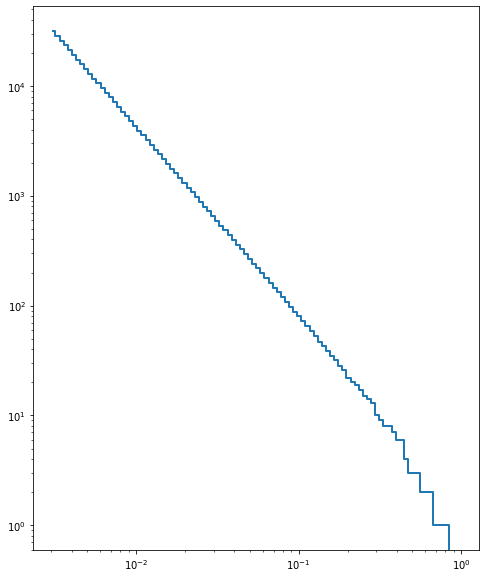

In [85]:
plt.figure(figsize=(8,10))
plt.plot(L_mids, nums, drawstyle='steps-mid', lw=2)
plt.yscale('log')
plt.xscale('log')

In [94]:
kvals = [1, 5, 10] # np.arange(1, 60, 1)
satfields = ['satall', 'sat12000', 'sat2019']

#plt.figure()

for satfield in satfields:
    probs = []
    scaled_probs = []
    
    nsbm1 = pd.read_hdf(satfield + '/sims/NSBM/data_0.1_1000_0.13_3.0.hdf', 
                        key='data')
    r1 = pd.read_hdf(satfield + '/sims/rayleigh/data_0.05_1000_0.13_3.0.hdf', 
                     key='data')
    r2 = pd.read_hdf(satfield + '/sims/rayleigh/data_0.04_1000_0.13_3.0.hdf', 
                     key='data')
    nsbm2 = pd.read_hdf(satfield + '/sims/NSBM/data_0.003_1000_0.13_3.0.hdf', 
                        key='data')
    
    scales = [1168, 1168, 1168, 333536, 333536, 333536]
    rlist = [nsbm1, r1, r2, nsbm2, r1, r2]
    names = ['nsbm1', 'r1', 'r2', 'nsbm2', 'r1', 'r2']
    
    for i, df in enumerate(rlist):
        print('\n' + satfield + ', ' + names[i])
        probs = []
        scaled_probs = []
        lam = np.sum(df.colprob.values)
        scaled_lam = np.sum(df.colprob.values)*scales[i]/len(df)
        
        for k in kvals:
            print('k = ', k)
            colprob = prob_more_than(lam, k)
            print(colprob) 
            probs.append(colprob)
            colprob_scaled = prob_more_than(scaled_lam, k)
            print(colprob_scaled) 
            scaled_probs.append(colprob_scaled)

        #plt.plot(kvals, probs, label=names[i])

#plt.legend()
#plt.xlabel('k')
#plt.ylabel('scaled probability of more than k collisions')




satall, nsbm1
k =  1
1.490884800000003
1.7391636000000044
k =  5
0.0
0.0
k =  10
0.0
0.0

satall, r1
k =  1
5.287791909999995
6.14829576
k =  5
3.7999999813465024e-07
8.10000000406319e-07
k =  10
0.0
0.0

satall, r2
k =  1
6.612804589999999
7.6800405900000035
k =  5
1.1799999977135656e-06
2.5399999992181677e-06
k =  10
0.0
0.0

satall, nsbm2
k =  1
0.6788453299999997
89.68853398
k =  5
0.0
8.05015376
k =  10
0.0
0.01305258999999559

satall, r1
k =  1
5.287791909999995
99.99999865
k =  5
3.7999999813465024e-07
99.99234622
k =  10
0.0
98.55892847

satall, r2
k =  1
6.612804589999999
99.99999998999999
k =  5
1.1799999977135656e-06
99.99983324
k =  10
0.0
99.90966293

sat12000, nsbm1
k =  1
0.31687088999999835
0.37000659999999463
k =  5
0.0
0.0
k =  10
0.0
0.0

sat12000, r1
k =  1
1.1631307200000052
1.3572050499999988
k =  5
0.0
0.0
k =  10
0.0
0.0

sat12000, r2
k =  1
1.465964360000005
1.7101292700000048
k =  5
0.0
0.0
k =  10
0.0
0.0

sat12000, nsbm2
k =  1
0.14390573000000462
38.141650